# 이해하기 : CRNN
- CRNN은 이미지로 부터 텍스트를 추출하는 알고리즘
- CNN으로 부터 얻은 특징 맵을 RNN의 입력으로 사용 (여기서는 GRU사용)

<img src="./figs/12_01.png">

- 입력 이미지를 CNN 입력으로 
- CNN추출된 입력은 시계열 형태로 바뀌어서 GRU에 입력
- 이미지의 가로 세로의 픽셀에서, 가로 방향을 시계열로 취급
- 이미지로 부터 추출된 특징의 세로 방향 픽셀의 값을 RNN층의 은닉 상태로 이용

<img src="./figs/12_02.png">

- RNN 층은 각 은닉 상태가 어떤 글자에 해당하는 가 분류
- 한 글자에 해당하는 은닉 상태는 서로 인접해 있어, 
- 겹쳐 있는 은닉 상태를 어떻게 구분해 낼지 궁리 해야

<img src="./figs/12_03.png">

- 글자를 표현하지 않는 픽셀은 공백('-')으로 분류
- 중복 제거 하면 연속된 문자로 표현
    - hh --> h, ee --> e
- e : ee, e-, -e, 하나의 문자를 여러 방법으로 표현
- CTC 손실 이용

# 이해하기 : CTC손실

<img src="./figs/12_04.png">

- CRNN에서 같은 문자를 여러 방식으로 표현 가능
- CTC(Connectionist Temporal Classification) 손실은, 가능한 모든 표현 방식을 고려, 손실을 계산하도록 설계된 함수
    - CTC 손실 : 하나의 정답을 표현하는 방법에 따라 여러가지 존재 할 때, 모든 경우의 수에 대한 확률을 더하는 함수
- t0와 t1 두 시점으로 정답 a라는 단어를 나타낸다고 가정
- a를 나타내는 표현으로는, aa, a-, -a 가 있음
- 각 시점은 서로 영향을 주지 않아, 각 시점에서의 출력을 곱하는 것으로 각 경로에 대한 확률을 구함
    - aa : 0.4*0.4 = 0.16
    - a- : 0.4*0.1 = 0.04
    - -a : 0.1*0.4 : 0.04
- a일 확률 : 0.16 + 0.04 + 0.04 = 0.24 
- 위와 같이 계산한 모든 경로의 합이 바로 CTC 손실
- CTC 기법은 시퀀스 분류를 위한 딥러닝 모델 맨 마지막에 손실(loss) 및 그래디언트 계산 레이어로 구현
- CTC 손실이 최소화 되도록 가중치를 학습하면, 정답에 대한 경로들의 확률을 최대화 하도록 신경망 학습 가능

# 데이터 살펴보기

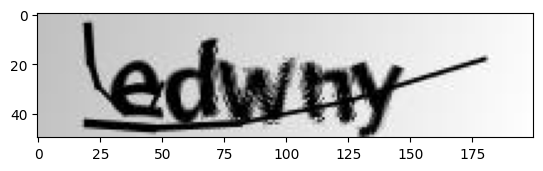

(50, 200, 4)


In [1]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image
import numpy as np

imgfile = glob.glob('./datasets/CH12/*.png')[0]
imgfile = Image.open(imgfile) 
# print(imgfile.shape)
plt.imshow(imgfile)
plt.show()

print(np.array(imgfile).shape)

- png 파일은 RGB 채널 + 투명도를 나타내는 알파 채널
- 세로 : 50 픽셀, 가로 : 200 픽셀, 채널 : 4

# 학습용 데이터셋 만들기
- 파일 이름과 동일한 이미지 내용
- '.png' 제외한 파일 이름이 정답

In [2]:
import numpy as np
from torch.utils.data.dataset import Dataset

# 문자열로 부터 BOW를 만드는 함수
def get_BOW(corpus):
    # 공백 문자 <pad>를 0으로 설정
    BOW = {'<pad>':0}
    
    # corpus의 문자열을 이용, BOW에 고유 번호 추가
    for letter in corpus:
        if letter not in BOW.keys():
            BOW[letter] = len(BOW.keys())
            
    return BOW

- get_BOW() 는 문자의 집합을 입력으로 받아 BOW 반환
- 공백 문자를 나타내는 토큰 : \<pad> 의 고유 번호를 0으로 설정
- 모든 문자로부터 BOW 생성
- BOW에 들어있지 않은 문자의 고유 번호를 corpus 안에 들어 있는 순서대로 부과

In [3]:
class Captcha(Dataset):
    def __init__(self, pth, train=True):
        # 소문자와 숫자만 정답으로 사용
        self.corpus = string.ascii_lowercase + string.digits
        self.BOW = get_BOW(self.corpus)
        
        # 불러올 이미지 파일의 경로
        self.imgfiles = glob.glob(pth + '/*.png')
        
        self.train = train
        self.trainset = self.imgfiles[:int(len(self.imgfiles)*0.8)]
        self.testset = self.imgfiles[int(len(self.imgfiles)*0.8):]      
        
    # 캡챠의 문자를 고유 번호(정답)로 치환
    def get_seq(self, line):
        label = []
        
        for letter in line:
            label.append(self.BOW[letter])
            
        return label
    
    # 데이터 개수를 반환하는 함수
    def __len__(self):
        if self.train:
            return len(self.trainset) # 책 오타?
        else:
            return len(self.testset)
        
    # 데이터를 불러오는 함수
    def __getitem__(self, i):
        if self.train:
            # png 파일을 RGP 파일로 변환
            data = Image.open(self.trainset[i]).convert("RGB")
            label = self.trainset[i].split("/")[-1]
            
        # 검증용 데이터 처리
        else:
            data = Image.open(self.testset[i]).convert("RGB")
            label = self.testset[i].split("/")[-1]            
            
        # 파일 이름에서 확장자 제거
        label = label.split(".png")[0]
        # 정답 문자열을 BOW의 순열로 변환
        label = self.get_seq(label)

        data = np.array(data).astype(np.float32)
        # 파이토치는 채널이 가장 앞에 와야 함
        data = np.transpose(data, (2, 0, 1))
        label = np.array(label)

        return data, label

# CRNN 모델 정의하기 : CNN
- CNN으로는 ResNet 사용, 단 이미지 모양이 달라졌기 때문에 이에 맞춰 수정
- 이미지 분류에서는 가로 세로가 같지만, 캡챠 데이터는 가로 픽셀수가 세로 픽셀수 보다 많은 직사각형 이미지
- 커널의 모양도 세로보다 가로가 더 길게 만들어 줘야
    - 입력에서 3x5 커널 사용 

<img src="./figs/12_05.png">

- RNN의 입력으로 들어가야 함으로, 세로 방향의 픽셀이 1개만 존재 해야
- 합성곱층을 거칠 때 마다, 세로 방향의 픽셀 수를 줄여 간다
- 세로 방향의 픽셀이 하나만 존재 하더라도, 채널 방향의 정보를 사용하면 RNN의 입력으로 들어가는 벡터의 형태 유지 가능
- 세로 방향의 픽셀은 합성곱 커널의 스트라이드를 조절해 줄인다
- 합성곱 마다 커널의 크기가 다르다 (3x5, 3x3)

<img src="./figs/12_06.png">

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 3x5 크기 커널 이용
# stride (2, 1) 는 세로로 2개의 픽셀, 가로로 1개의 픽셀을 건너 뛰는 것을 의미
class BasicBlock(nn.Module):
    def __init__(self, 
                in_channels,
                out_channels,
                kernel_size=(3,5),
                stride=(2,1)):
        super(BasicBlock, self).__init__()
        
        # 3x5 모양의 커널을 사용하는 합성곱층
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride)
        
        # 3x3 모양의 커널을 사용하는 합성곱층
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding=1)  
        
        self.downsample = nn.Conv2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=kernel_size,
                                   stride=stride)
        
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)        
        
        self.relu = nn.ReLU()
    
    # ResNet 기본 블록의 순전파
    def forward(self, x):
        x_ = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        x_ = self.downsample(x_)
        
        x += x
        x = self.relu(x)
        
        return x

# CRNN 모델 정의하기 : 전체 모델

- CNN의 특징은 GRU에 입력 하기 위해, 채널 정보와 픽섹의 순서를 바꿔 주어야
- 파이토치는 채널이 맨 앞에 옴
- GRU는 픽셀 간 순서 정보 학습을 해야

<img src="./figs/12_07.png">

- CNN의 결과로 세로 픽셀이 하나의 특징 맵으로 출력
- 가로 픽셀 하나당 채널 정보를 하나의 백터로 묶어
- 가로 픽셀의 방향을 시계열로 취급해 GRU의 입력으로 사용
- GRU는 각 픽셀이 어떤 문자를 표현 했는지 예측

<img src="./figs/12_08.png">

- 기본 블록을 4번 거침
    - 합성곱 블록을 한 번 거칠 때 마다 이미지의 세로 길이가 절반이 됨
    - 네번을 거치면 세로 픽셀 개수가 2
- 마지막 합성곱의 커널 크기를 2x5로 설정, 세로 픽셀 개수가 1이 됨 

In [5]:
class CRNN(nn.Module):
    def __init__(self, output_size):
        super(CRNN,self).__init__()
        
        # CNN층 정의
        self.c1 = BasicBlock(in_channels=3, out_channels=64)
        self.c2 = BasicBlock(in_channels=64, out_channels=64)
        self.c3 = BasicBlock(in_channels=64, out_channels=64)
        self.c4 = BasicBlock(in_channels=64, out_channels=64)
        self.c5 = nn.Conv2d(64, 64, kernel_size=(2, 5))
        
        # 텍스트 정볼르 추출할 GRU 층
        self.gru = nn.GRU(64, 64, batch_first=False)
        
        # 분류를 위한 MLP 층, 어떤 문자가 존재 하는지 분류
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # 입력 텐서의 모양 (B, 3, 50, 200) : (배치, 채널, 세로, 가로)
        x = self.c1(x)
        x = self.c2(x)
        x = self.c3(x)       
        x = self.c4(x)        
        x = self.c5(x)        
        # 특징 추출 후 텐서의 모양 (B, 64,  1, 180) : (배치, 채널, 세로, 가로)
        
        # (B, 64, 180) 으로 모양 변경
        x = x.view(x.shape[0], 64, -1)
        # (180, B, 64) 로 모양 변경 : (시계열 길이, 배치, 채널)
        x = x.permute(2, 0, 1)
        
        # GRU로 시계열 정보 추출
        x, _ = self.gru(x)
        
        # MLP 층으로 각 픽셀 분류
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        # CTC 손실 계산을 위해 로그 소프트맥스 사용
        x = F.log_softmax(x, dim=-1)
        
        return x

# 모델 학습하기

<img src="./figs/12_09.png">

- CTC 학습은 가능한 모든 경로의 확률을 합해 이용
- 경로 계산을 하려면 계산하고자 하는 텐서들의 모양과 함께 모델의 출력을 CTC 손실 함수에 입력해 줘야

In [6]:
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
from torch.utils.data import DataLoader

trainset = Captcha(pth='./datasets/CH12/', train=True)
loader = DataLoader(trainset, batch_size=8)

In [8]:
model = CRNN(output_size=len(trainset.BOW)).to(device)
optim = Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CTCLoss(blank=0)

- `blank` 옵션은 `CTCLoss` 함수의 매개변수 중 하나입니다. `CTCLoss`는 Connectionist Temporal Classification(CTC) 알고리즘을 사용하여 시퀀스 레벨의 분류 문제를 다루는 데 사용되는 손실 함수입니다.

- CTC 알고리즘은 입력 시퀀스와 대응하는 레이블 시퀀스 사이의 매핑 문제를 해결하기 위해 사용됩니다. 이때 입력 시퀀스와 레이블 시퀀스의 길이가 다를 수 있습니다. CTC 알고리즘은 입력 시퀀스와 레이블 시퀀스 사이의 일대다 또는 다대다 매핑을 수행하며, 중간에 "blank" 심볼을 포함하여 시퀀스 사이의 정렬을 유지합니다.

- `blank` 옵션은 레이블 시퀀스에서 사용되는 blank 심볼의 인덱스를 지정합니다. blank 심볼은 입력과 레이블 시퀀스의 매핑에서 "아무 것도 없음"을 나타내는 역할을 합니다. 이 심볼은 입력 시퀀스에서 연속으로 나타나거나 레이블 시퀀스에서 생략될 수 있습니다. `blank` 옵션의 기본값은 0입니다.

- `CTCLoss` 함수에서 `blank` 옵션을 사용하면 blank 심볼을 고려하여 손실을 계산합니다. blank 심볼은 입력 시퀀스에서 중복으로 나타날 수 있고, 레이블 시퀀스에서는 생략될 수 있으므로, `CTCLoss`는 입력 시퀀스에서의 중복을 제거하고 레이블 시퀀스에서의 생략을 보상합니다.

- 결론적으로, `blank` 옵션은 CTC 알고리즘의 매핑 문제에서 "아무 것도 없음"을 나타내는 심볼의 인덱스를 지정하는 역할을 합니다.
- 위에서 \<pad> 를 '0'으로 설정

In [14]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    
    # 정답에 사용할 label
    for data, label in iterator:
        optim.zero_grad()
        
        # CRNN 출력값
        preds = model(data.to(device)) 
        
        # CTC 손실 계산시, 텐서의 모양까지 넣어 주어야
        # 정수형으로 간단하게 preds, labels 의 모양을 만들어 주자
        
        # 시계열을 묶는 모양을 나타내는 변수, 아래와 같이 CTL loss 의 에러를 위해 수정
#         preds_size = torch.IntTensor([preds.size(0)]*8).to(device)
        preds_size = torch.IntTensor([preds.size(0)]*label.shape[0]).to(device)
        
        # 정답의 모양을 나타내는 변수
        target_len = torch.IntTensor([len(txt) for txt in label]).to(device)
        
        # 손실 계산
#         print('=='*8)
#         print('preds shape', preds.shape)
#         print('label shape', label.shape)        
#         print('preds_size shape', preds_size)  
#         print('target_len shape', target_len)          
        loss = loss_fn(preds, label.to(device), preds_size, target_len)
        
        loss.backward()
        optim.step()
        
        iterator.set_description(f'epoch : {epoch+1}, loss : {loss.item()}')
        
torch.save(model.state_dict(), './models/CRNN.pth')        

epoch : 72, loss : 0.003950354177504778: 100%|█| 84/84 [00:00<00:00, 112.01it/s]
epoch : 73, loss : 0.0036586597561836243: 100%|█| 84/84 [00:00<00:00, 111.38it/s
epoch : 74, loss : 0.0033956686966121197: 100%|█| 84/84 [00:00<00:00, 111.21it/s
epoch : 76, loss : 0.00293911574408412: 100%|██| 84/84 [00:00<00:00, 111.25it/s]
epoch : 77, loss : 0.0027383272536098957: 100%|█| 84/84 [00:00<00:00, 111.48it/s
epoch : 80, loss : 0.002224959898740053: 100%|█| 84/84 [00:00<00:00, 111.22it/s]
epoch : 81, loss : 0.0020782460924237967: 100%|█| 84/84 [00:00<00:00, 111.10it/s
epoch : 82, loss : 0.0019459869945421815: 100%|█| 84/84 [00:00<00:00, 112.69it/s
epoch : 83, loss : 0.001820450066588819: 100%|█| 84/84 [00:00<00:00, 112.82it/s]
epoch : 84, loss : 0.0017067883163690567: 100%|█| 84/84 [00:00<00:00, 112.50it/s
epoch : 85, loss : 0.0015993252163752913: 100%|█| 84/84 [00:00<00:00, 111.70it/s
epoch : 86, loss : 0.001501886872574687: 100%|█| 84/84 [00:00<00:00, 111.51it/s]
epoch : 87, loss : 0.0014086

# 모델 성능 평가하기
- 180개를 순서대로 예측
- 결과 확인을 하려면 글자간 중복 제거
- 공백 문자를 예측하거나 이전과 같은 문자를 예측하면 중복 의미, 
- 이전 단어를 기록하며 예측 결과 확인 필요

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


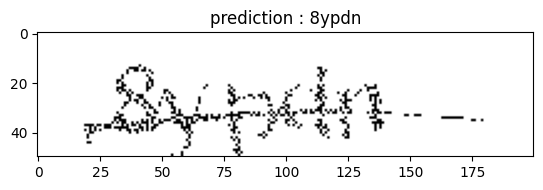

In [43]:
import random

model.load_state_dict(torch.load('./models/CRNN.pth', map_location=device))

with torch.no_grad():
    testset = Captcha(pth='./datasets/CH12/', train=False)
    
    idx = random.randint(0, len(testset))
    test_img, label = testset[idx]
    input_tensor = torch.unsqueeze(torch.tensor(test_img).to(device) , dim=0)
    
    # 가장 높은 확률을 갖는 글자 추출
    pred = torch.argmax(model(input_tensor), dim=-1)
    
    # 글자간 중복 제거
    prev_letter = pred[0].item()
    pred_word = ""
    for letter in pred:
        if letter.item() != 0 and letter.item() != prev_letter:
            pred_word += list(testset.BOW.keys())[letter.item()]
            
        prev_letter = letter.item()
    
    plt.imshow(test_img.transpose((1, 2, 0)))
    plt.title('prediction : '+pred_word)
    plt.show()

# 학습 마무리

<img src="./figs/12_12.png">

# 연습문제

<img src="./figs/12_10.png">

<img src="./figs/12_11.png">